In [1]:
%load_ext autoreload

In [2]:
from __future__ import division, print_function
import os
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from utils.UL_uncert import UL_uncert
from acor import acor
from corner import corner

%matplotlib inline
%autoreload 2

In [3]:
def trace_plot(chain, pars,
               cols=3, wid_per_col=4, aspect=4/3,
               kwargs={}):

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].plot(chain[:,pp], **kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig


def hist_plot(chain, pars, bins=30,
              cols=3, wid_per_col=4, aspect=4/3,
              kwargs={}):
    hist_kwargs = {
        'density':True,
        'histtype':'step',
    }
    for key, val in kwargs.items():
        hist_kwargs[key] = val

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].hist(chain[:,pp], bins=bins, **hist_kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig

def bayes_fac(samples, Nmin=200, logAmin=-18, logAmax=-9,
              dAmin=0.01, dAmax=0.5):
    """
    Computes the Savage Dickey Bayes Factor and uncertainty.

    :param samples: MCMC samples of GWB (or common red noise) amplitude
    :param ntol: Tolerance on number of samples in bin

    :returns: (bayes factor, 1-sigma bayes factor uncertainty)
    """

    prior = 1 / (logAmax - logAmin)
    dA = np.linspace(dAmin, dAmax, 100)
    bf = []
    bf_err = []
    mask = [] # selecting bins with more than 200 samples

    for ii, delta in enumerate(dA):
        n = np.sum(samples <= (logAmin + delta))
        N = len(samples)

        post = n / N / delta

        bf.append(prior/post)
        bf_err.append(bf[ii]/np.sqrt(n))

        if n > Nmin:
            mask.append(ii)

    return np.mean(np.array(bf)[mask]), np.std(np.array(bf)[mask])

In [326]:
TMIN = 53217.0
TMAX = 57387.0
tchunk = np.linspace(TMIN, TMAX, 41)  # break in 2.5% chunks
tlim = []
for ii in range(len(tchunk)-2):
    tlim.append(tchunk[ii:ii+3])

ii_t = 29  # 0-40 or None
if ii_t:
    TMIN, CENTER, TMAX = tlim[ii_t]
    chunk = '{:.2f}'.format(CENTER)
else:
    chunk = 'all'

In [327]:
logA_ch = {}
psr_name = 'J1909-3744'

# LinearExp

In [328]:
# set rundir for prior test runs!
prior = 'uniform'

rundir = os.path.join('/home/pbaker/nanograv/bwm/sngl', '{}_{}'.format(psr_name, prior), chunk)
with open(rundir + '/params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
if prior == 'true-uniform':
    idx_A = par_bwm.index('bwm_A')
else:
    idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                        sep='\t', dtype=float, header=None).values

burnfrac = 0.25
thin = 2

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_P = chain[:,-5]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

logA_ch['LinearExp'] = chain_bwm[:, idx_A]

N = 18713, corL = 2.93561211916


In [329]:
np.vstack([chain_bwm[:,1], chain_bwm[:,2], chain_L, chain_P]).shape

(4, 18713)

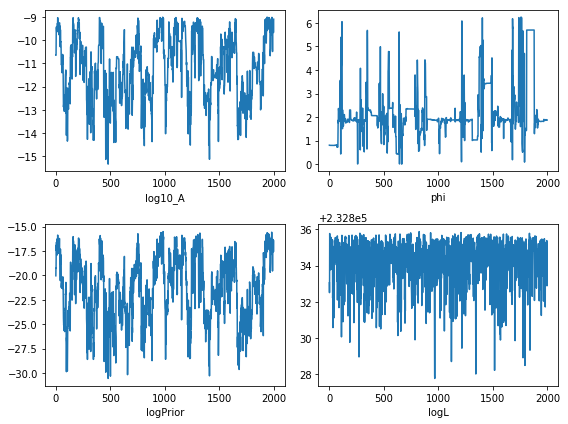

In [330]:
trace_plot(
    np.vstack([chain_bwm[1000:3000,1],
               chain_bwm[1000:3000,2],
               chain_P[1000:3000]-chain_L[1000:3000],
               chain_L[1000:3000],
              ]).T,
    pars=['log10_A', 'phi', 'logPrior', 'logL'],
    cols=2,
);

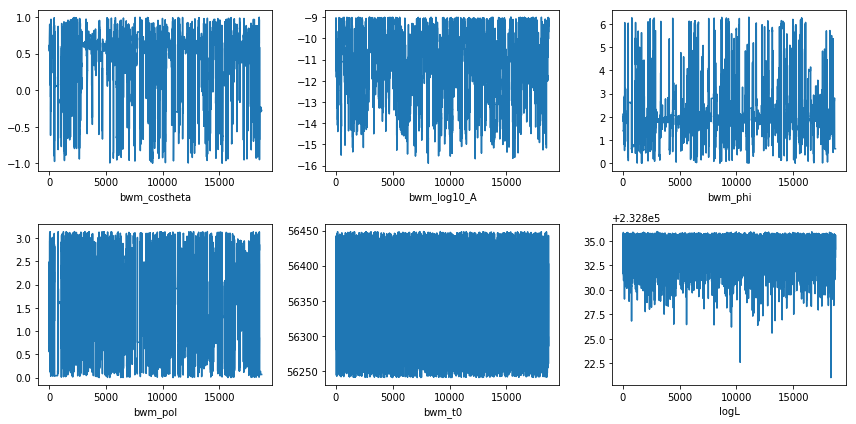

In [331]:
ch_plt = np.hstack([chain_bwm, chain_L.reshape(N,1)])
par_plt = par_bwm + ['logL']
trace_plot(ch_plt, par_plt, cols=3, wid_per_col=4);

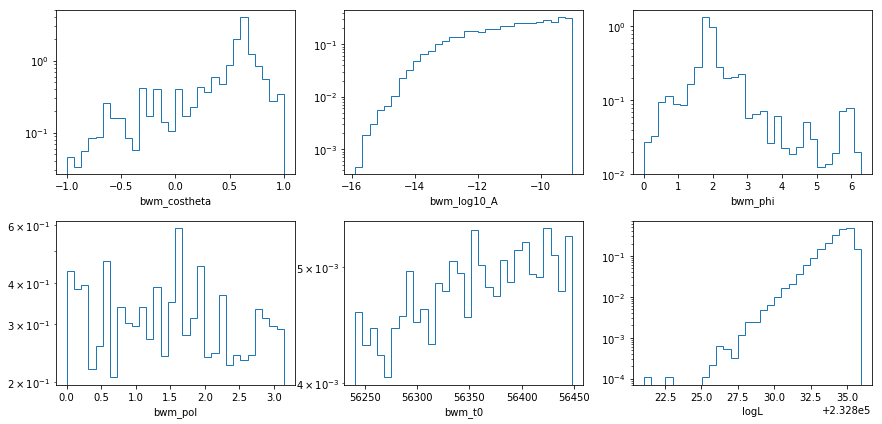

In [332]:
fig = hist_plot(ch_plt, par_plt, cols=3, wid_per_col=4)
for ax in fig.axes:
    ax.set_yscale('log')

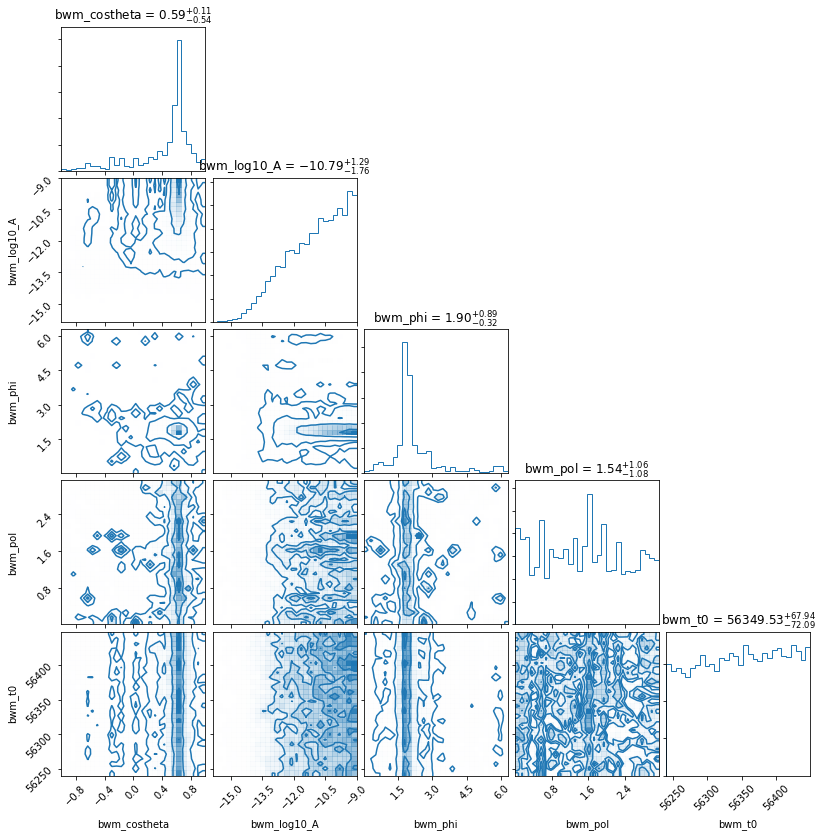

In [333]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);

# "true" Uniform

In [334]:
# set rundir for prior test runs!
prior = 'true-uniform'

rundir = os.path.join('/home/pbaker/nanograv/bwm/sngl', '{}_{}'.format(psr_name, prior), chunk)

with open(rundir + '/params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
if prior == 'true-uniform':
    idx_A = par_bwm.index('bwm_A')
else:
    idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                        sep='\t', dtype=float, header=None).values

burnfrac = 0.25
thin = 2

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_P = chain[:,-5]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

logA_ch['trueUniform'] = np.log10(chain_bwm[:, idx_A])

N = 18713, corL = 2.28911779428


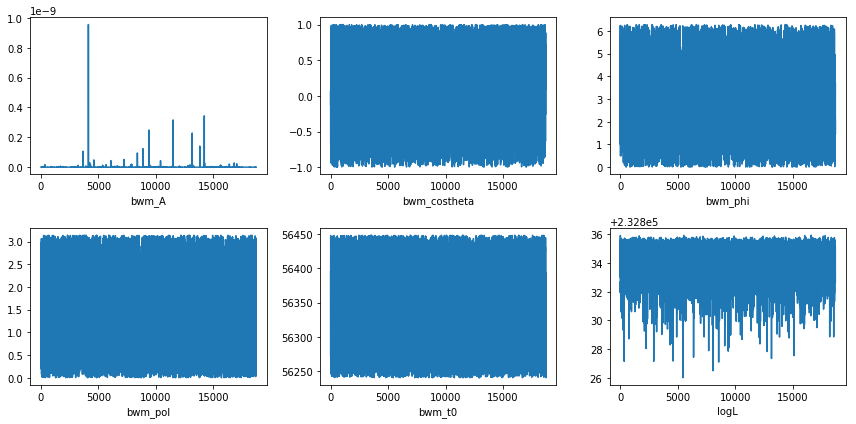

In [335]:
ch_plt = np.hstack([chain_bwm, chain_L.reshape(N,1)])
par_plt = par_bwm + ['logL']
trace_plot(ch_plt, par_plt, cols=3, wid_per_col=4);

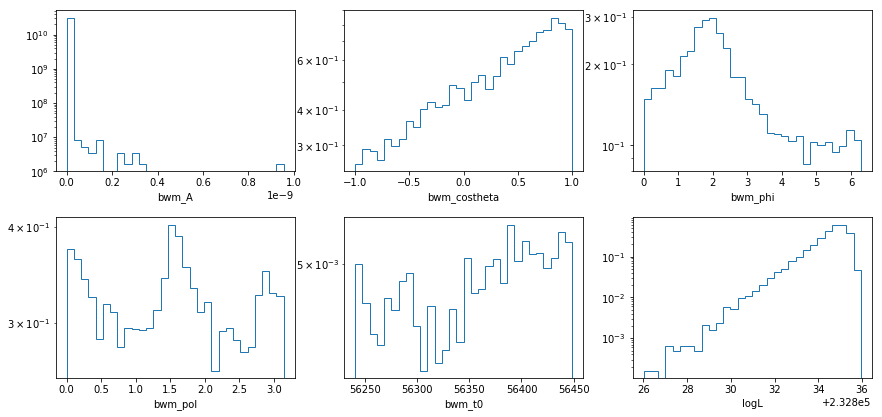

In [336]:
fig = hist_plot(ch_plt, par_plt, cols=3, wid_per_col=4)
for ax in fig.axes:
    ax.set_yscale('log')

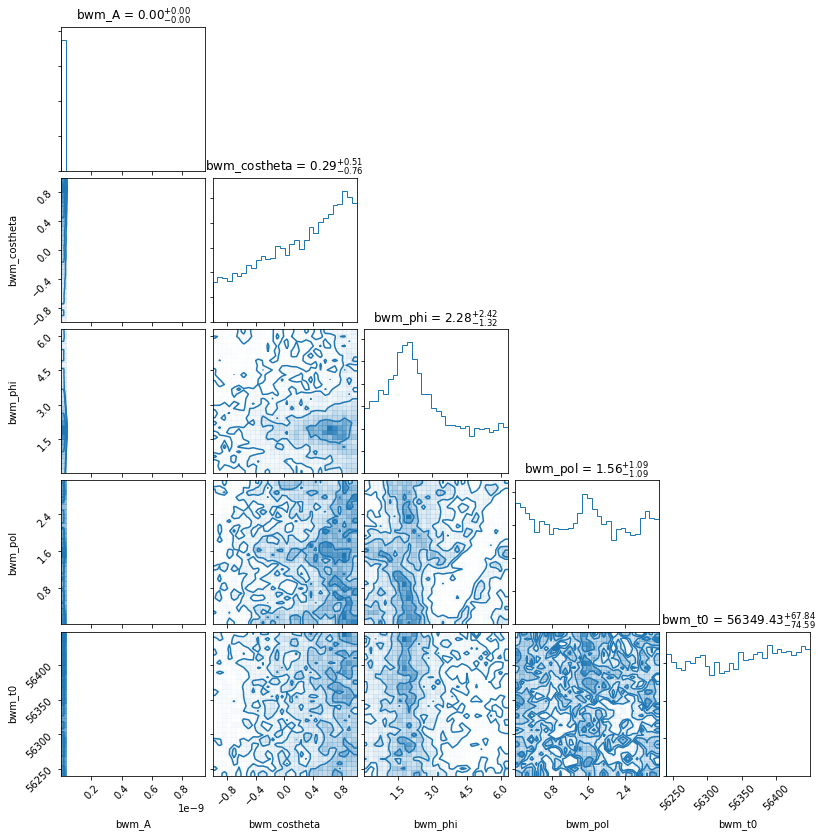

In [337]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);

# compare

In [338]:
for name, chain in logA_ch.items():
    print(name, UL_uncert(10**chain))

trueUniform (3.3077242413999924e-13, 2.088453436156556e-14)
LinearExp (7.027685314321973e-10, 5.159656307724333e-11)


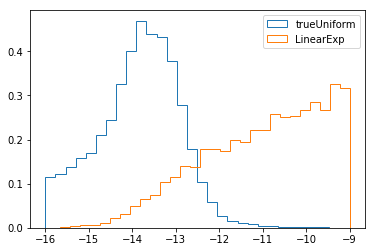

In [339]:
for name, chain in logA_ch.items():
    plt.hist(chain, bins=30, histtype='step', density=True, label=name)
plt.legend()

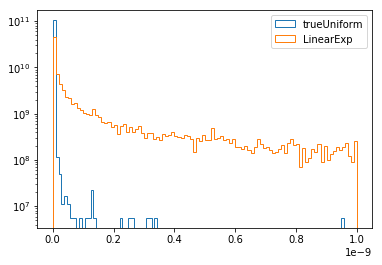

In [340]:
for name, chain in logA_ch.items():
    plt.hist(10**chain, bins=100, histtype='step', density=True, label=name)
plt.yscale('log')
plt.legend()

In [477]:
logA_ch_wide = {}

# set rundir for prior test runs!
prior = 'uniform'

rundir = os.path.join('/home/pbaker/nanograv/bwm/sngl', '{}_{}_wide'.format(psr_name, prior), chunk)
with open(rundir + '/params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
if prior == 'true-uniform':
    idx_A = par_bwm.index('bwm_A')
else:
    idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                        sep='\t', dtype=float, header=None).values

burnfrac = 0.25
thin = 2

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_P = chain[:,-5]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

logA_ch_wide['LinearExp'] = chain_bwm[:, idx_A]

N = 18713, corL = 3.83112456336


In [342]:
# set rundir for prior test runs!
prior = 'true-uniform'

rundir = os.path.join('/home/pbaker/nanograv/bwm/sngl', '{}_{}_wide'.format(psr_name, prior), chunk)

with open(rundir + '/params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
if prior == 'true-uniform':
    idx_A = par_bwm.index('bwm_A')
else:
    idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                        sep='\t', dtype=float, header=None).values

burnfrac = 0.25
thin = 2

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_P = chain[:,-5]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

logA_ch_wide['trueUniform'] = np.log10(chain_bwm[:, idx_A])

N = 18713, corL = 2.44582174573


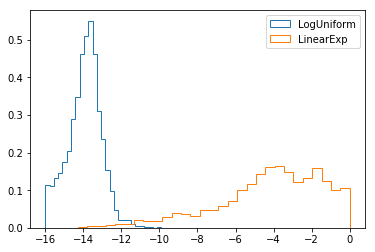

In [471]:
plt.hist(logA_ch_wide['trueUniform'], bins=30, histtype='step', density=True, label='LogUniform')
plt.hist(logA_ch_wide['LinearExp'], bins=30, histtype='step', density=True, label='LinearExp')
plt.legend()

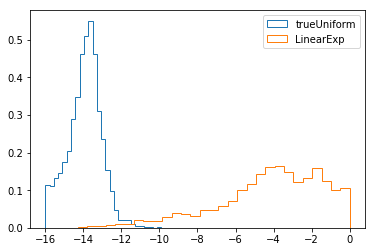

In [343]:
for name, chain in logA_ch_wide.items():
    plt.hist(chain, bins=30, histtype='step', density=True, label=name)
plt.legend()

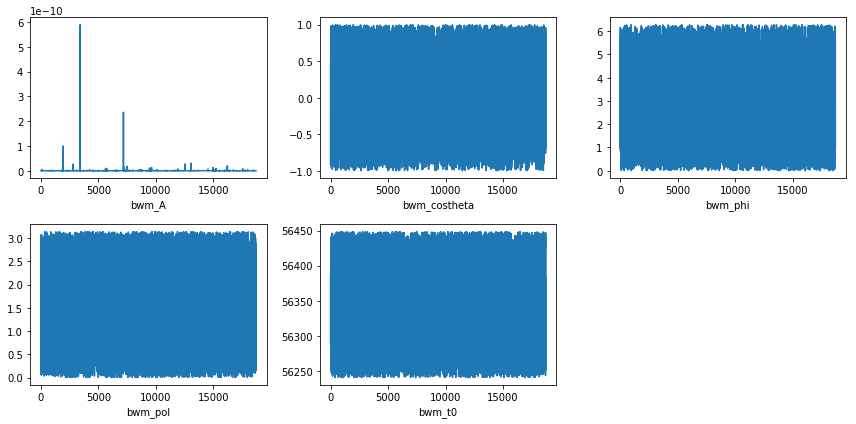

In [344]:
trace_plot(chain_bwm, par_bwm, cols=3);

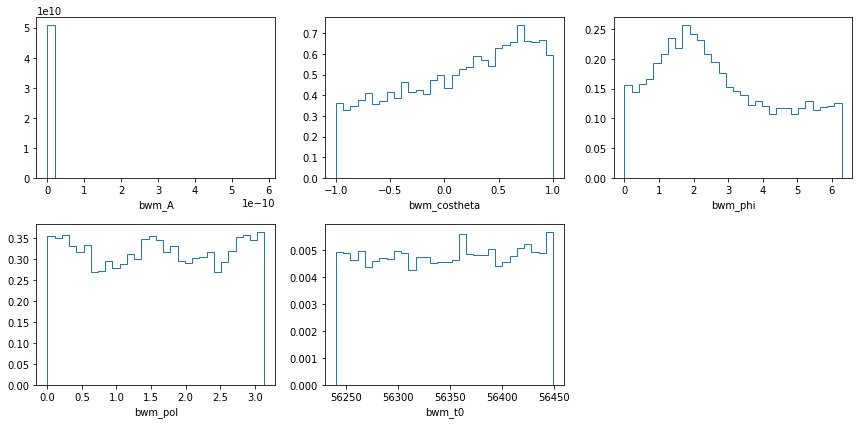

In [345]:
hist_plot(chain_bwm, par_bwm, cols=3);

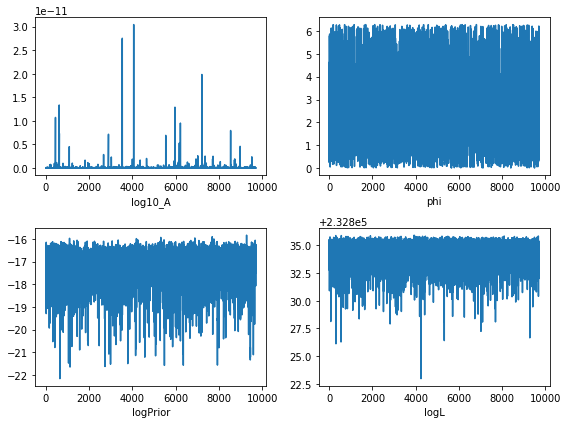

In [346]:
trace_plot(
    np.vstack([chain_bwm[9000:,0],
               chain_bwm[9000:,2],
               chain_P[9000:]-chain_L[9000:],
               chain_L[9000:],
              ]).T,
    pars=['log10_A', 'phi', 'logPrior', 'logL'],
    cols=2,
);

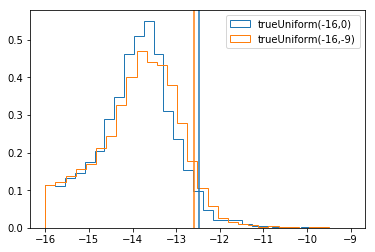

In [347]:
UL, dUL = UL_uncert(logA_ch['trueUniform'])
UL_wide, dUL_wide = UL_uncert(logA_ch_wide['trueUniform'])

plt.hist(logA_ch_wide['trueUniform'], label='trueUniform(-16,0)',
         bins=30, color='C0',
         histtype='step',
         density=True)
plt.hist(logA_ch['trueUniform'], label='trueUniform(-16,-9)',
         bins=30, color='C1',
         histtype='step',
         density=True)
plt.axvline(x=UL, color='C0')
plt.axvline(x=UL_wide, color='C1')

plt.legend()

In [348]:
print(10**UL, 10**UL_wide)

3.3077241200570313e-13 2.555539655611562e-13


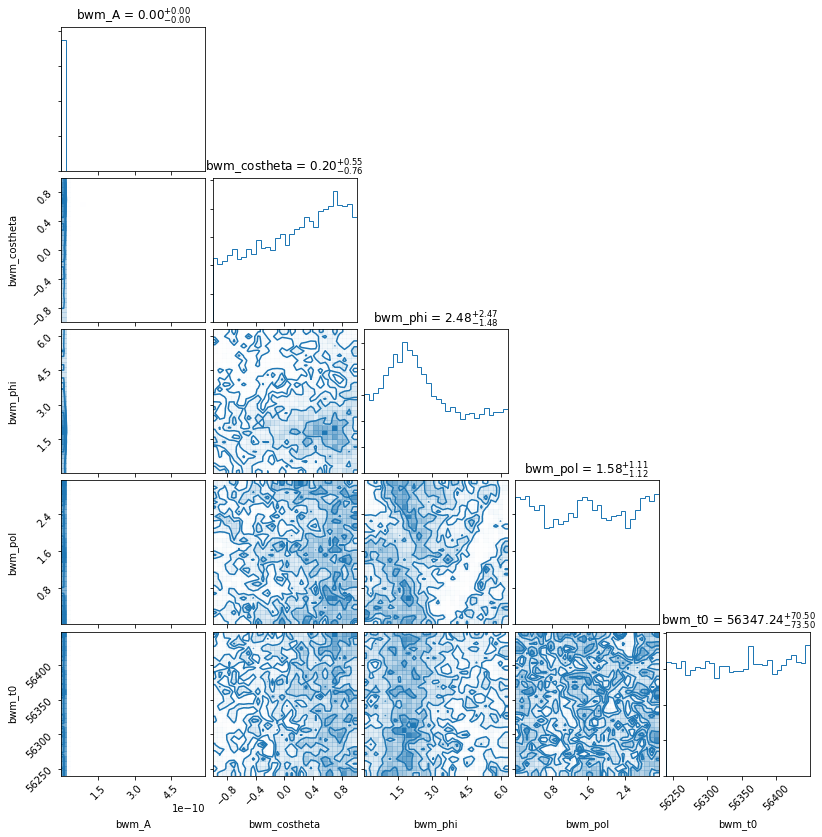

In [349]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);

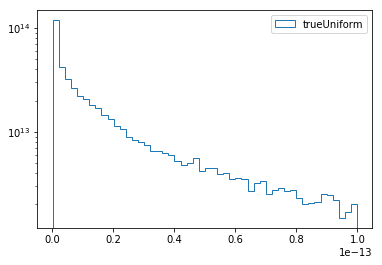

In [350]:
mask = logA_ch['trueUniform'] < -13
plt.hist(10**logA_ch['trueUniform'][mask], bins=50, histtype='step', density=True, label='trueUniform');
plt.yscale('log')
plt.legend();

In [385]:
logA_ch_low = {}

# set rundir for prior test runs!
prior = 'true-uniform'

rundir = os.path.join('/home/pbaker/nanograv/bwm/sngl', '{}_{}_low'.format(psr_name, prior), chunk)
with open(rundir + '/params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
if prior == 'true-uniform':
    idx_A = par_bwm.index('bwm_A')
else:
    idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                        sep='\t', dtype=float, header=None).values

burnfrac = 0.25
thin = 2

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_P = chain[:,-5]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

logA_ch_low['trueUniform'] = np.log10(chain_bwm[:, idx_A])

N = 18300, corL = 1.98618860927


In [472]:
A_ch_zero = {}

# set rundir for prior test runs!
prior = 'true-uniform'

rundir = os.path.join('/home/pbaker/nanograv/bwm/sngl', '{}_{}_noLUjump'.format(psr_name, prior), chunk)
with open(rundir + '/params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
if prior == 'true-uniform':
    idx_A = par_bwm.index('bwm_A')
else:
    idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                        sep='\t', dtype=float, header=None).values

burnfrac = 0.25
thin = 2

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_P = chain[:,-5]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

A_ch_zero['trueUniform'] = chain_bwm[:, idx_A]

N = 18713, corL = 3.86125392586


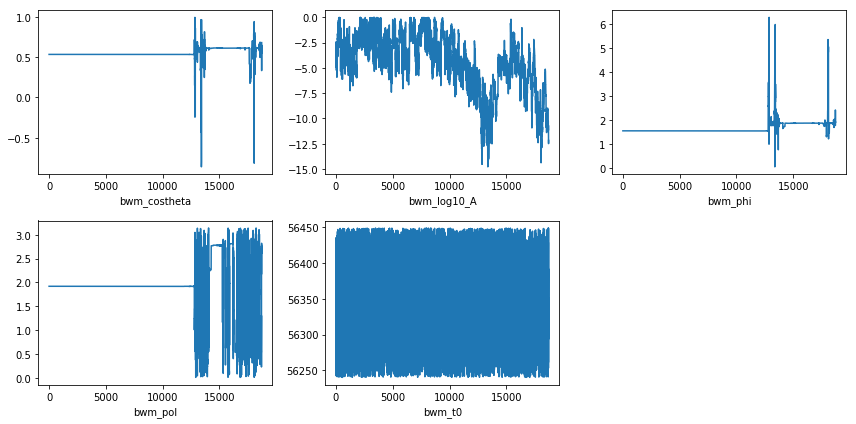

In [478]:
trace_plot(chain_bwm, par_bwm,);

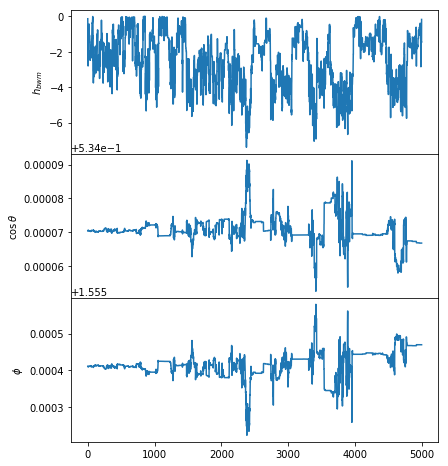

In [487]:
# [left, bottom, width, height]
tbox = [0.1, 0.60, 0.85, 0.25]
mbox = [0.1, 0.35, 0.85, 0.25]
bbox = [0.1, 0.10, 0.85, 0.25]

fig = plt.figure(figsize=(6,8))

ax1 = fig.add_axes(tbox)
ax1.plot(chain_bwm[2500:7500, 1])
ax1.set_ylabel('$h_{bwm}$')

ax2 = fig.add_axes(mbox)
ax2.plot(chain_bwm[2500:7500, 0])
ax2.set_ylabel(r'$\cos\,\theta$')

ax3 = fig.add_axes(bbox)
ax3.plot(chain_bwm[2500:7500, 2])
ax3.set_ylabel('$\phi$')

#ax1.set_yscale('log')
ax1.set_xticklabels([])
ax2.set_xticklabels([]);


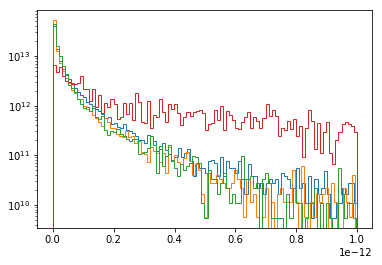

In [467]:
hist_kwargs = {
    'bins': 100,
    'density': True,
    'histtype': 'step',
}



mask = logA_ch['trueUniform'] < -12
plt.hist(10**logA_ch['trueUniform'][mask], **hist_kwargs);

mask = logA_ch_low['trueUniform'] < -12
plt.hist(10**logA_ch_low['trueUniform'][mask], **hist_kwargs);

mask = logA_ch_wide['trueUniform'] < -12
plt.hist(10**logA_ch_wide['trueUniform'][mask], **hist_kwargs);

mask = np.logical_and(chain_bwm[:, idx_A] < 1e-12, chain_bwm[:, idx_A]>0)
plt.hist(chain_bwm[mask, idx_A], **hist_kwargs);

plt.yscale('log')

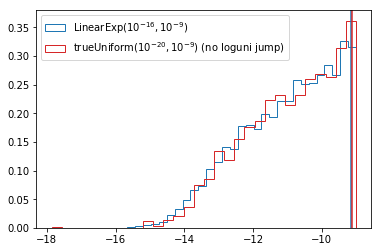

In [469]:
UL = np.percentile(10**logA_ch['LinearExp'], 95)
UL_zero = np.percentile(chain_bwm[:, idx_A], 95)

plt.hist(logA_ch['LinearExp'], label='LinearExp($10^{-16},10^{-9}$)',
         bins=30, color='C0',
         histtype='step',
         density=True)
plt.hist(np.log10(A_ch_zero['trueUniform']), label='trueUniform($10^{-20},10^{-9}$) (no loguni jump)',
         bins=30, color='C3',
         histtype='step',
         density=True)

plt.axvline(x=np.log10(UL), color='C0')
plt.axvline(x=np.log10(UL_zero), color='C3')

plt.legend()

In [470]:
print(UL, UL_zero)

7.027685314321973e-10 7.435161329638198e-10


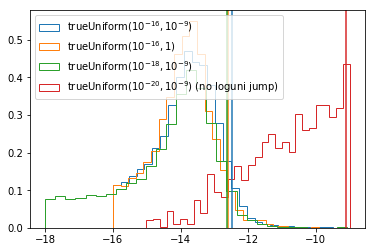

In [463]:
mask = A_ch_zero['trueUniform'] > 0


UL = np.percentile(10**logA_ch['trueUniform'], 95)
UL_low = np.percentile(10**logA_ch_low['trueUniform'], 95)
UL_wide = np.percentile(10**logA_ch_wide['trueUniform'], 95)
UL_zero = np.percentile(chain_bwm[:, idx_A], 95)

plt.hist(logA_ch['trueUniform'], label='trueUniform($10^{-16},10^{-9}$)',
         bins=30, color='C0',
         histtype='step',
         density=True)
plt.hist(logA_ch_wide['trueUniform'], label='trueUniform($10^{-16},1$)',
         bins=30, color='C1',
         histtype='step',
         density=True)
plt.hist(logA_ch_low['trueUniform'], label='trueUniform($10^{-18},10^{-9}$)',
         bins=30, color='C2',
         histtype='step',
         density=True)
plt.hist(np.log10(A_ch_zero['trueUniform'][mask]), label='trueUniform($10^{-20},10^{-9}$) (no loguni jump)',
         bins=30, color='C3',
         histtype='step',
         density=True)

plt.axvline(x=np.log10(UL), color='C0')
plt.axvline(x=np.log10(UL_wide), color='C1')
plt.axvline(x=np.log10(UL_low), color='C2')
plt.axvline(x=np.log10(UL_zero), color='C3')

plt.legend()

In [450]:
print(UL, UL_wide, UL_low, UL_zero)

3.3077242413999924e-13 2.555541651999982e-13 2.3993047824999963e-13 7.409800918048985e-10


# Sngl PSR BF test

In [253]:
psr_name = 'J1744-1134'
chunk = 'all'

In [319]:
# set rundir for prior test runs!
prior = 'log-uniform'

rundir = os.path.join('/home/pbaker/nanograv/bwm/sngl/det_DE436', psr_name, chunk)
with open(rundir + '/params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
if prior == 'true-uniform':
    idx_A = par_bwm.index('bwm_A')
else:
    idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                        sep='\t', dtype=float, header=None).values

burnfrac = 0.25
thin = 5

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_P = chain[:,-5]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

N = 3420, corL = 26.776932777


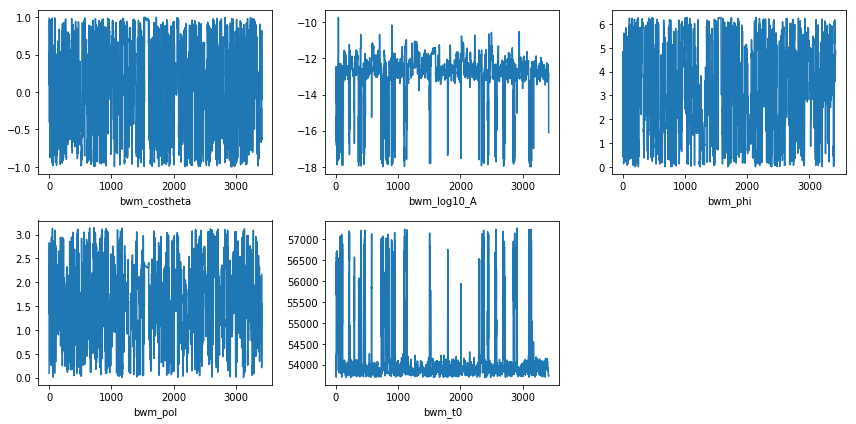

In [320]:
trace_plot(chain_bwm, par_bwm, cols=3);

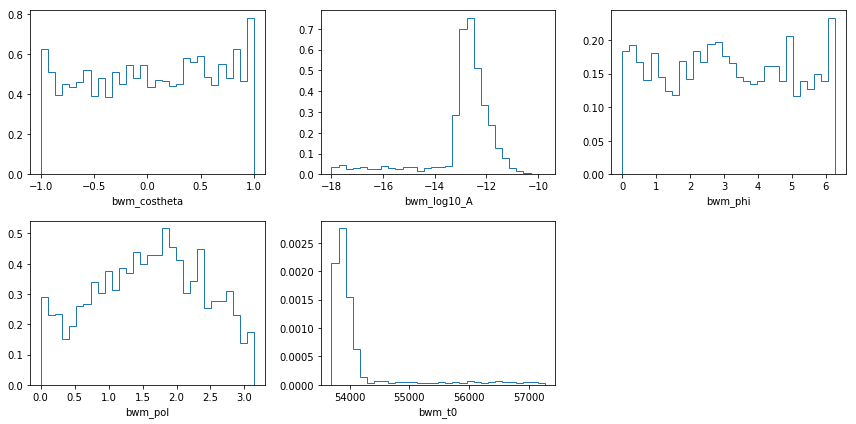

In [321]:
hist_plot(chain_bwm, par_bwm, cols=3);

In [322]:
BF, dBF = bayes_fac(chain_bwm[:,idx_A], Nmin=50)
print(BF, dBF)

2.971742620937413 0.05214707455030171


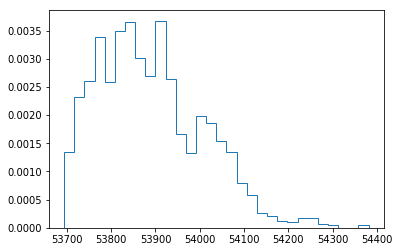

In [323]:
mask1 = chain_bwm[:,idx_A] > -14
mask2 = chain_bwm[:, idx_t0] < 54400
mask = np.logical_and(mask1, mask2)
plt.hist(chain_bwm[mask, idx_t0], bins=30, histtype='step', density=True);

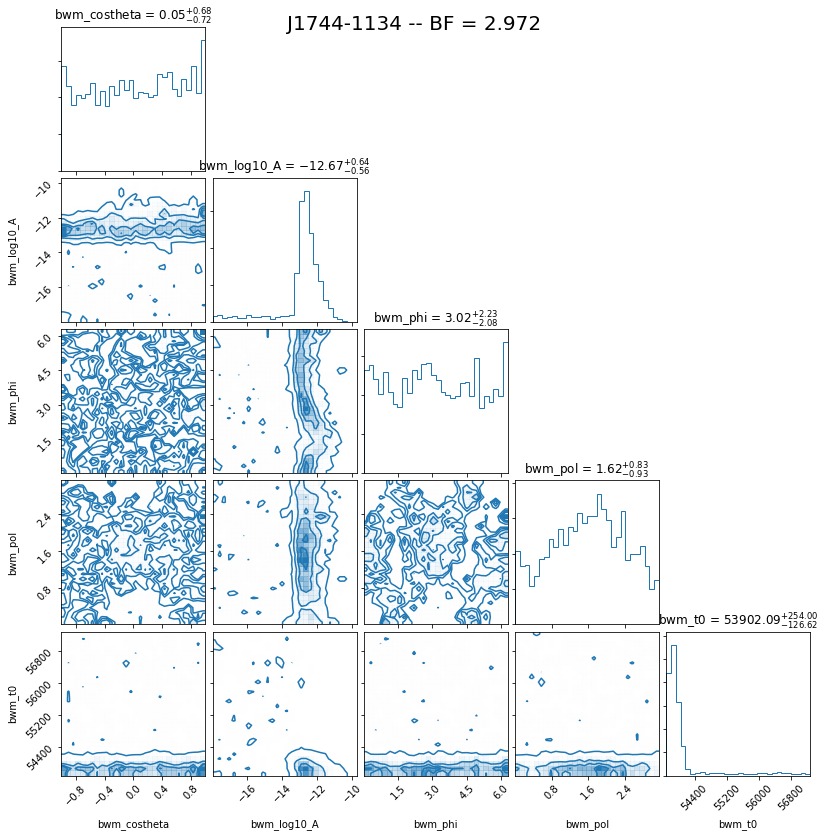

In [324]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);
fig.suptitle("{:s} -- BF = {:.3f}".format(psr_name, BF), fontsize=20);

In [563]:
# set rundir for prior test runs!
psr_name, ii_t = 'J1909-3744', 29
psr_name, ii_t = 'J1713+0747', 11
prior = 'uniform'

TMIN, CENTER, TMAX = tlim[ii_t]
chunk = '{:.2f}'.format(CENTER)
    

rundir = os.path.join('/home/pbaker/nanograv/bwm/sngl', '{}_{}_trick'.format(psr_name, prior), chunk)
with open(rundir + '/params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
if prior == 'true-uniform':
    idx_A = par_bwm.index('bwm_A')
else:
    idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                        sep='\t', dtype=float, header=None).values

burnfrac = 0.25
thin = 2

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_P = chain[:,-5]
chain_L = chain[:,-4]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

N = 18713, corL = 1.98579523512


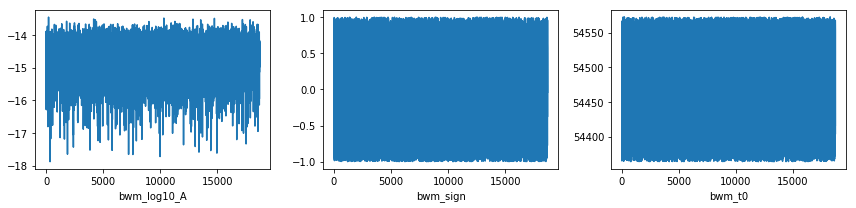

In [564]:
trace_plot(chain_bwm, par_bwm, cols=3);

sky ave UL: h < 2.273e-14


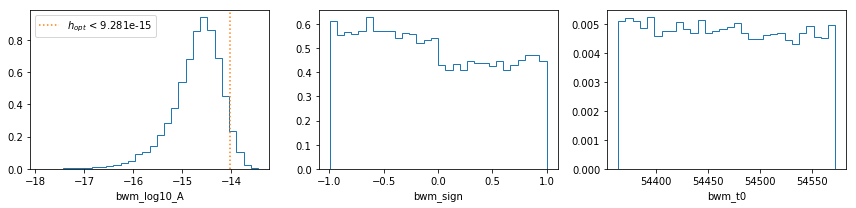

In [565]:
UL = np.percentile(chain_bwm[:,idx_A], 95)

fig = hist_plot(chain_bwm, par_bwm, cols=3);
fig.axes[0].axvline(x=UL, ls=':', color='C1', label='$h_{{opt}}$ < {:.3e}'.format(10**UL))
fig.axes[0].legend()
print("sky ave UL: h < {:.3e}".format(10**UL * np.sqrt(6)))

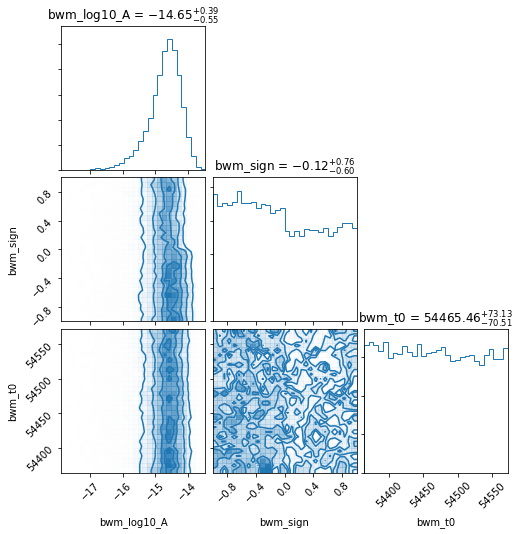

In [566]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);

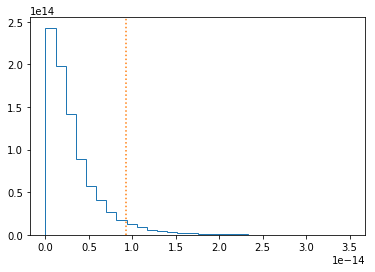

In [568]:
plt.hist(10**chain_bwm[:, idx_A], bins=30, color='C0',
         histtype='step', density=True)
plt.axvline(x=10**UL, ls=':', color='C1', label='$h_{{opt}}$ < {:.3e}'.format(10**UL))